In [1]:
%matplotlib inline

import numpy as np

import pandas as pd
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

import bayes_multilevel as bm
from bambi import Model

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all th

In [2]:
arousal_data_raw = pd.read_csv('../data/study_5/study_5_data.csv')

In [3]:
arousal_data_raw.head()

,subID,stimFile,stimType,valenceRating,arousalRating
0,0,sa/boo_walk_sa_1_fin.mp4,videos,24,71
1,0,ha/dun_walk_ha_1_fin.mp4,videos,41,33
2,0,L/16b03La.wav,sounds,72,51
3,0,W/09a01Wb.wav,sounds,19,82
4,0,an/mac_walk_an_2_fin.mp4,videos,39,78


In [4]:
arousal_data = pd.read_csv('../Experiment - many arousal levels/universalContours_042018_data.csv')
bdes_data = pd.read_csv('bdes_scs_big.csv')
paco_data = pd.read_csv('paco_scs.csv')

scs = []
sources = []
for row in arousal_data.iterrows():
    stim_file = row[1]['stimFile']
    if stim_file[-3:] == 'mp4':
        target = stim_file[3:-4] + '.ptd'
        if target == 'chr_walk_nu_1_fin.ptd':
            sc = None
        else:
            sc = float(paco_data[paco_data['path'] == target]['mean_sc'])
        source = 0
    elif stim_file[-3:] == 'wav':
        target = stim_file[2:]
        sc = float(bdes_data[bdes_data['Path'] == target]['Speaker-Standardized Mean SC'])
        source = 1
    scs.append(sc)
    sources.append(source)

arousal_data['modalitySound'] = sources
arousal_data['sc'] = scs
arousal_data = arousal_data.dropna()

arousal_data['valenceRating'] = zscore(arousal_data['valenceRating'])
arousal_data['arousalRating'] = zscore(arousal_data['arousalRating'])
arousal_data.loc[arousal_data['modalitySound'] == 0, 'sc'] = zscore(arousal_data.loc[arousal_data['modalitySound'] == 0, 'sc'])

# This is fucked up but fixes a problem where Bambi thinks there's missing data
arousal_data.to_csv('arousal_data.csv')
arousal_data = pd.read_csv('arousal_data.csv')
arousal_data.head()

,Unnamed: 0,subID,stimFile,stimType,valenceRating,arousalRating,modalitySound,sc
0,0,0,sa/boo_walk_sa_1_fin.mp4,videos,-0.804167,0.739000,0,-0.268913
1,1,0,ha/dun_walk_ha_1_fin.mp4,videos,-0.025175,-0.758358,0,0.882766
2,2,0,L/16b03La.wav,sounds,1.395339,-0.049084,1,-0.436832
3,3,0,W/09a01Wb.wav,sounds,-1.033282,1.172445,1,-0.138854
4,4,0,an/mac_walk_an_2_fin.mp4,videos,-0.116821,1.014829,0,1.909666


In [5]:
arousal_data_raw['stimFile'].unique().shape

(775,)

In [6]:
arousal_data_raw['subID'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [55]:
arousal_data_raw.groupby('subID')['stimFile'].agg(['count'])

,count
subID,
0,165
1,165
2,220
3,220
4,220
5,220
6,220
7,220
8,220


In [7]:
arousal_data_raw.groupby('subID')['stimFile'].agg(['count']).values.sum()

10934

In [21]:
def linreg_plot(data, x='arousalRating', y='sc', title=None, x_label=None, y_label=None): 
    if x_label is None:
        x_label = 'Arousal rating (z-scored)'
    if y_label is None:
        y_label = 'Spectral centroid (z-scored)'
    sns.set(font_scale=1.5)
    sns.set_style('white')
    sns.regplot(
        data=data, 
        x=x, 
        y=y,
        line_kws={'color': '#333333ff'},
        scatter_kws={'color': '#99999999'},
    )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if title is not None:
        plt.title(title)
    sns.despine(left=True, bottom=True)

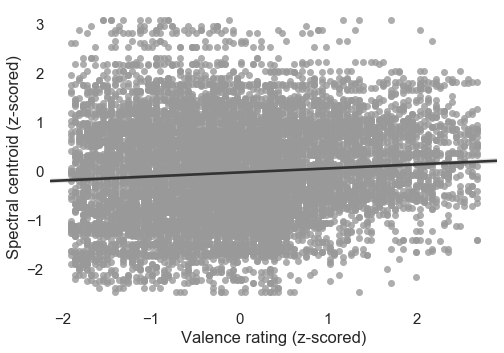

In [9]:
linreg_plot(arousal_data, x='valenceRating', x_label="Valence rating (z-scored)")

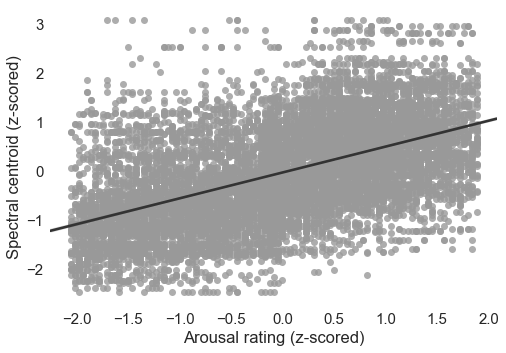

In [10]:
linreg_plot(arousal_data)

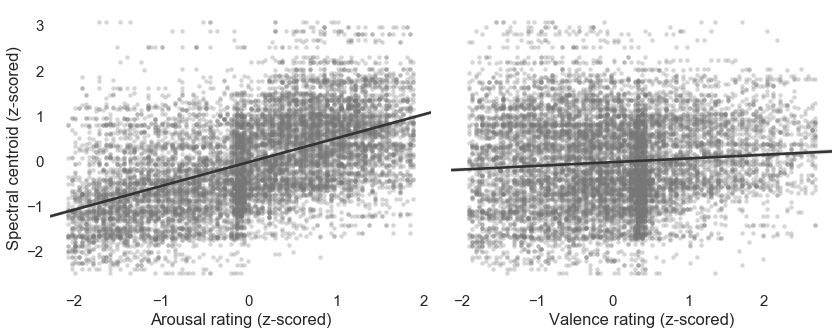

In [54]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
dotsize = 20
alpha = .3
dotcolor = '#777777'
sns.set(font_scale=1.5)
sns.set_style('white')
sns.regplot(
    data=arousal_data, 
    x='arousalRating', 
    y='sc',
    line_kws={'color': '#333333ff'},
    scatter_kws={'color': dotcolor, 's': dotsize, 'alpha': alpha},
    ax=ax1
)
sns.regplot(
    data=arousal_data, 
    x='valenceRating', 
    y='sc',
    line_kws={'color': '#333333ff'},
    scatter_kws={'color': dotcolor, 's': dotsize, 'alpha': alpha},
    ax=ax2
)
ax1.set_ylabel("Spectral centroid (z-scored)")
ax2.set_ylabel("")
ax1.set_xlabel("Arousal rating (z-scored)")
ax2.set_xlabel("Valence rating (z-scored)")
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [ ]:
samples = 1500
chains = 4
n_splits = 5

arousal_fold_data_big = bm.bambi_cv_r2(
    arousal_data, 
    model_string = 'sc ~ arousalRating + modalitySound', 
    model_dict = {
        'random': ['arousalRating|subID'],
        'categorical': ['modalitySound', 'subID'],
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits,
    dv='sc'
)

In [ ]:
arousal_fold_data_big

In [ ]:
np.mean(arousal_fold_data_big[0])

In [17]:
samples = 1500
chains = 4
n_splits = 5

#samples = 100
#chains = 1
#n_splits = 2

arousal_fold_data_big = bm.bambi_cv_r2(
    arousal_data, 
    model_string = 'sc ~ valenceRating * arousalRating * modalitySound', 
    model_dict = {
        'random': ['arousalRating|subID', 'valenceRating|subID'],
        'categorical': ['modalitySound', 'subID'],
        'samples': samples, 
        'chains': chains, 
        'init': None
    }, 
    n_splits=n_splits,
    dv='sc',
    debug=False
)

Assigned NUTS to Intercept
INFO:pymc3:Assigned NUTS to Intercept
Assigned NUTS to modalitySound
INFO:pymc3:Assigned NUTS to modalitySound
Assigned NUTS to valenceRating
INFO:pymc3:Assigned NUTS to valenceRating
Assigned NUTS to valenceRating:modalitySound
INFO:pymc3:Assigned NUTS to valenceRating:modalitySound
Assigned NUTS to arousalRating
INFO:pymc3:Assigned NUTS to arousalRating
Assigned NUTS to arousalRating:modalitySound
INFO:pymc3:Assigned NUTS to arousalRating:modalitySound
Assigned NUTS to valenceRating:arousalRating
INFO:pymc3:Assigned NUTS to valenceRating:arousalRating
Assigned NUTS to valenceRating:arousalRating:modalitySound
INFO:pymc3:Assigned NUTS to valenceRating:arousalRating:modalitySound
Assigned NUTS to 1|subID_sd_log__
INFO:pymc3:Assigned NUTS to 1|subID_sd_log__
Assigned NUTS to 1|subID_offset
INFO:pymc3:Assigned NUTS to 1|subID_offset
Assigned NUTS to arousalRating|subID_sd_log__
INFO:pymc3:Assigned NUTS to arousalRating|subID_sd_log__
Assigned NUTS to arousalRat

In [18]:
arousal_fold_data_big

([0.33341280601293355,
  0.26739399566976585,
  0.3008347103734036,
  0.30912905564061743,
  0.3048064635140201],
  <bambi.models.Model at 0x121bbcba8>])

In [19]:
np.mean(arousal_fold_data_big[0])

0.3031154062421481

In [20]:
print(bm.summary_table(arousal_fold_data_big[1]))

|                                                |     M |   SD |   CI lower |   CI upper |   Effective N |   Gelman-Rubin |
|:-----------------------------------------------|------:|-----:|-----------:|-----------:|--------------:|---------------:|
| 1\|subID_sd                                     |  0.06 | 0.01 |       0.03 |       0.09 |        2158.8 |              1 |
| Intercept                                      |  0.15 | 0.02 |       0.11 |       0.19 |        4727.4 |              1 |
| arousalRating                                  |  0.76 | 0.03 |       0.71 |       0.81 |        2467.4 |              1 |
| arousalRating:modalitySound[T.1]               | -0.22 | 0.02 |      -0.27 |      -0.18 |        5628.6 |              1 |
| arousalRating\|subID_sd                         |  0.12 | 0.02 |       0.09 |       0.16 |        2062.2 |              1 |
| modalitySound[T.1]                             | -0.27 | 0.02 |      -0.3  |      -0.23 |        5993.2 |              1 